<a href="https://colab.research.google.com/github/tylee33/DLforFinance/blob/master/Hierarchical_Risk_Parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hierarchical Risk Parity - Implementation & Experiments (Part I)**

In this blog, we start to implement and test the ``Hierarchical Risk Parity’’ approach proposed by Marcos Lopez de Prado in his paper Building Diversified Portfolios that Outperform Out-of-Sample and his book Advances in Financial Machine Learning.

We will try to improve the methodology in following blog entries.

The ``Hierarchical Risk Parity’’ is a method to perform asset allocation without the need to invert a covariance matrix. It essentially computes a hierarchical tree (using a standard hierarchical clustering algorithm) from the correlation matrix, and then diversifies accross the different clusters.

We will proceed as follow:

We build an artificial correlation matrix C with several hierarchical clusters
We transform C into a covariance matrix Sigma
We sample time series from a normal distribution N(0, Sigma)
We apply the Hierarchical Risk Parity on these time series

In [0]:
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
%matplotlib inline


nb_alphas = 250
nb_observations = int(0.3 * 252)

# build a hierarchical block diagonal correlation matrix
quality = 0.6 * np.ones((nb_alphas // 6, nb_alphas // 6))
value = 2.4 * np.ones((nb_alphas // 2, nb_alphas // 2))
momentum = 2.6 * np.ones((int(nb_alphas * (1 - 1/6 - 1/2) + 1),
                          int(nb_alphas * (1 - 1/6 - 1/2) + 1)))

correl_mom_value = -1.2 * np.ones((int(nb_alphas * (1 - 1/6)) + 1,
                                   int(nb_alphas * (1 - 1/6)) + 1))


correl = (block_diag(quality, correl_mom_value) +
          block_diag(quality, momentum, value)) / 3
np.fill_diagonal(correl, 1)



mean_returns = np.zeros(nb_alphas)
volatilities = ([np.sqrt(0.1 / np.sqrt(252))] * (nb_alphas // 3) + 
                [np.sqrt(0.3 / np.sqrt(252))] * (nb_alphas - nb_alphas // 3 - nb_alphas // 6) + 
                [np.sqrt(0.5 / np.sqrt(252))] * (nb_alphas // 6))
covar = np.multiply(correl,
                    np.outer(np.array(volatilities),
                             np.array(volatilities)))
covar = pd.DataFrame(covar)

In [2]:
correl

array([[1. , 0.4, 0.4, ..., 0. , 0. , 0. ],
       [0.4, 1. , 0.4, ..., 0. , 0. , 0. ],
       [0.4, 0.4, 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0.4, 0.4],
       [0. , 0. , 0. , ..., 0.4, 1. , 0.4],
       [0. , 0. , 0. , ..., 0.4, 0.4, 1. ]])

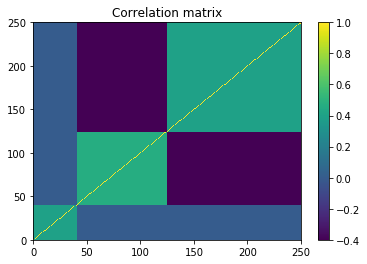

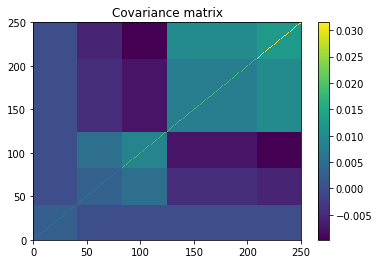

In [3]:
plt.pcolormesh(correl)
plt.colorbar()
plt.title('Correlation matrix')
plt.show()

plt.pcolormesh(covar)
plt.colorbar()
plt.title('Covariance matrix')
plt.show()

In [0]:
alphas_returns = np.random.multivariate_normal(
    mean_returns, cov=covar, size=nb_observations)

alphas_returns = pd.DataFrame(alphas_returns)

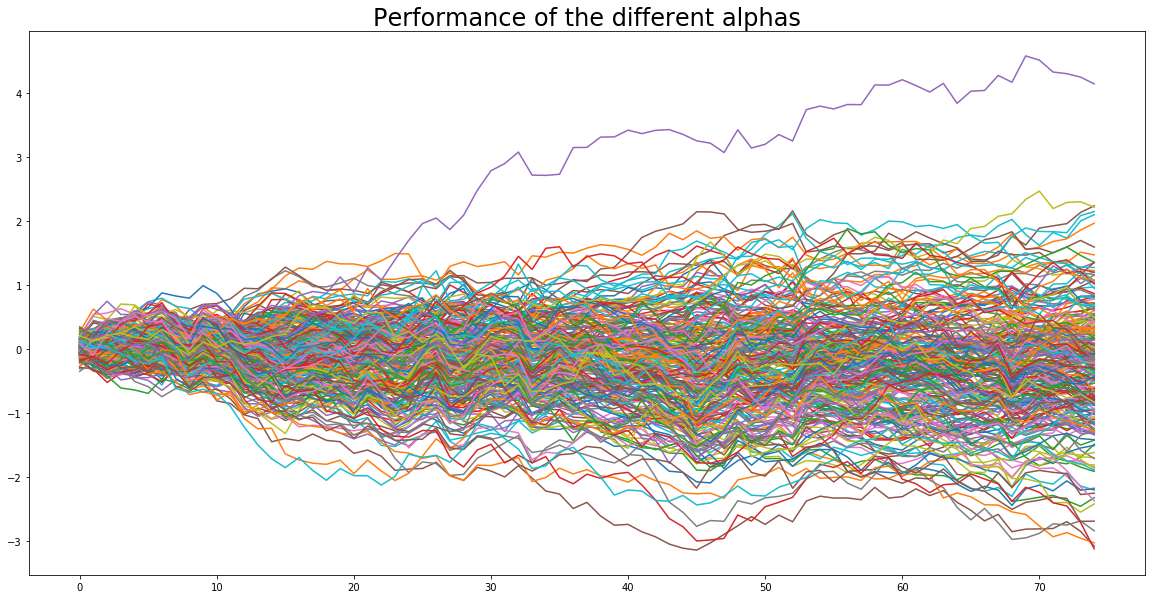

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(alphas_returns.cumsum())
plt.title('Performance of the different alphas', fontsize=24)
plt.show()

In a real setting, these time series are given, they are the observed returns of a bunch of assets (e.g. stocks, proprietary alphas).

# **First step is to estimate the correlation matrix**

In [0]:
estimate_correl = alphas_returns.corr(method='pearson')
estimate_covar = alphas_returns.cov()

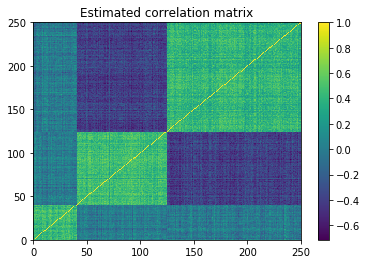

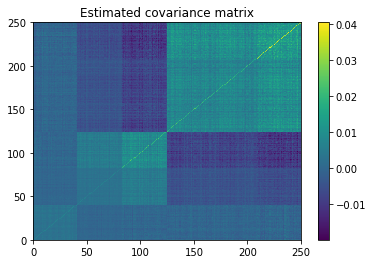

In [7]:
plt.pcolormesh(estimate_correl)
plt.colorbar()
plt.title('Estimated correlation matrix')
plt.show()

plt.pcolormesh(estimate_covar)
plt.colorbar()
plt.title('Estimated covariance matrix')
plt.show()

We convert the correlations into distances as follow:

In [0]:
distances = np.sqrt((1 - estimate_correl) / 2)

# **Second step is performing the quasi-diagonalization**

Then, Lopez de Prado applies what he calls a ``quasi-diagonalization’’, a process usually known as matrix seriation and which can be performed using hierarchical clustering as described in my blog post How to sort a distance matrix. Code that I will reuse here.

In [0]:
def seriation(Z, N, cur_index):
    """Returns the order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

    
def compute_serial_matrix(dist_mat, method="ward"):
    """Returns a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    """
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [0]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(distances.values, method='single')

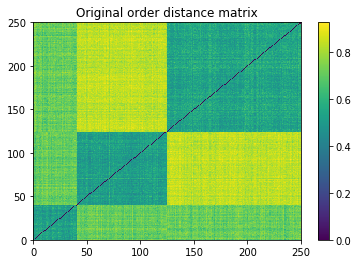

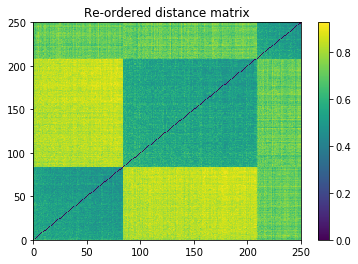

In [11]:
plt.pcolormesh(distances)
plt.colorbar()
plt.title('Original order distance matrix')
plt.show()

plt.pcolormesh(ordered_dist_mat)
plt.colorbar()
plt.title('Re-ordered distance matrix')
plt.show()

# **Third step is the Lopez de Prado’s recursive bisection:**

In [0]:
def compute_HRP_weights(covariances, res_order):
    weights = pd.Series(1, index=res_order)
    clustered_alphas = [res_order]

    while len(clustered_alphas) > 0:
        clustered_alphas = [cluster[start:end] for cluster in clustered_alphas
                            for start, end in ((0, len(cluster) // 2),
                                               (len(cluster) // 2, len(cluster)))
                            if len(cluster) > 1]
        for subcluster in range(0, len(clustered_alphas), 2):
            left_cluster = clustered_alphas[subcluster]
            right_cluster = clustered_alphas[subcluster + 1]

            left_subcovar = covariances[left_cluster].loc[left_cluster]
            inv_diag = 1 / np.diag(left_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

            right_subcovar = covariances[right_cluster].loc[right_cluster]
            inv_diag = 1 / np.diag(right_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

            alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)

            weights[left_cluster] *= alloc_factor
            weights[right_cluster] *= 1 - alloc_factor
            
    return weights


def compute_MV_weights(covariances):
    inv_covar = np.linalg.inv(covariances)
    u = np.ones(len(covariances))
    
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))


def compute_RP_weights(covariances):
    weights = (1 / np.diag(covariances)) 
    
    return weights / sum(weights)


def compute_unif_weights(covariances):
    
    return [1 / len(covariances) for i in range(len(covariances))]

# **Let’s look at the volatility of the portfolio in-sample**

For curiosity, we display the results computed using the estimated covariance matrix and using the original covariance matrix that was used to sample the time series. We hope that the results are somewhat similar…

**Hierarchical Risk Parity**

In [13]:
# in-sample HRP annualized volatility

# using estimated covariance

HRP_weights = compute_HRP_weights(estimate_covar, res_order)

print(round((HRP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.39


In [14]:
# using original covariance (not observed in practice)

HRP_weights = compute_HRP_weights(covar, res_order)

print(round((HRP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.35


**1 / N uniform weighting**

In [15]:
# in-sample 1 / N annualized volatility
unif_weights = compute_unif_weights(estimate_covar)

print(round((unif_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.46


**Naive Risk Parity 1 / volatility**

In [16]:
# in-sample naive risk parity normalized(1 / vol) volatility

# using estimated covariance matrix
RP_weights = compute_RP_weights(estimate_covar)

print(round((RP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.3


In [17]:
# using original covariance matrix (not observed in practice)
RP_weights = compute_RP_weights(covar)

print(round((RP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.31


**Minimum Variance**

In [18]:
# in-sample Minimum Variance annualized volatility

# using estimated covariance matrix
MV_weights = compute_MV_weights(estimate_covar)

print(round((MV_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.0


In [19]:
# using original covariance matrix (in practice, not observed)
MV_weights = compute_MV_weights(covar)

print(round((MV_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.22


# **Validation out-of-sample**
We generate another sample, i.e. time series of returns over a two-year horizon.

In [0]:
nb_observations = int(2 * 252)

alphas_returns = np.random.multivariate_normal(
    mean_returns, cov=covar, size=nb_observations)

alphas_returns = pd.DataFrame(alphas_returns)

**Hierarchical Risk Parity**

In [21]:
# out-sample HRP annualized volatility

# using the covariance estimated in-sample

HRP_weights = compute_HRP_weights(estimate_covar, res_order)

print(round((HRP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.47


**1 / N uniform weighting**

In [22]:
# out-sample 1 / N annualized volatility
unif_weights = compute_unif_weights(estimate_covar)

print(round((unif_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.45


**Naive Risk Parity 1 / volatility**

In [23]:
# out-sample naive risk parity normalized(1 / vol) volatility

# using the covariance estimated in-sample
RP_weights = compute_RP_weights(estimate_covar)

print(round((RP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

0.29


In [24]:
# out-sample Minimum Variance annualized volatility

# using the covariance estimated in-sample
MV_weights = compute_MV_weights(estimate_covar)

print(round((MV_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),2))

2.16


We notice indeed that the Minimum Variance (with a basic and too naive covariance matrix estimator…) yields overfitted solutions that do not produce out-of-sample performing portfolios.

On this (too?) simple example, the Hierarchical Risk Parity doesn’t beat its most naive Risk Parity counterpart which totally ignores the correlation structure between the assets. However, this example may be too simple for the HRP to shine. In a following blog post, we will perform a more extensive comparison of the different approaches using a Monte Carlo study:

*   Many different correlation models
*   Sampling from different distributions (with tails)
*   Using different hierarchical clustering methodologies

